# Simulating Images with Unstacked PSFs and Mirror Moves

For a significant part of the JWST commissioning process (until around MIMF-3, expected L+118 days), the JWST OTE will not be optimally aligned. The mirrors will be unstacked and unphased, and thus the nominal JWST PSFs that MIRaGe uses when creating imaging simulations do not adequately represent this type of telescope state.

In particular, this notebook can be used to simulate __OTE-03__, __OTE-04__, and __OTE-06__ activities.

In this notebook, we demonstrate how to use MIRaGe to simulate early commissioning images using unstacked PSFs. The process is as follows:
- Parse APT output files to access the details and structure of a given program.
- Generate PSF libraries for the desired mirror state for each visit/exposure in a given observation, using `webbpsf` or existing FITS files. There should be N+1 PSF libraries, where N is the number of groups of mirror moves.
- Generate MIRaGe YAML input files that include the directory in which to find the the nonnominal PSF libraries.
- Generate seed images from those YAML files that use the appropriate PSF library for the desired exposures. Follow the nominal procedures for adding dark exposure and detector effects.

### Table of Contents:
1. [Export program information from APT](#export_apt)
2. [Create diverse PSF library files](#create_psfs)
3. [Create `.yaml` files for each exposure](#make_yamls)
4. [Generate the simulated image](#simulate_images)

Appendix A: [Generating data for an entire observation](#simulate_whole_obs)

Appendix B: [Combining data into a mosaic](#mosaic)

## Import necessary packages and modules

In [2]:
# Standard Library Imports
from glob import glob
import os
import pprint
import shutil
import time

# Third Party Imports
from astropy.io import fits
from matplotlib import cm
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import numpy as np
import pysiaf
import webbpsf

# Local Imports (from nircam_simulator package)
from mirage import imaging_simulator
from mirage.apt import apt_inputs, read_apt_xml
from mirage.catalogs import get_catalog
from mirage.utils.utils import ensure_dir_exists
from mirage.yaml import yaml_generator

from mirage.psf import psf_selection, deployments, segment_psfs

import jwxml

# View matplotlib plots inline
%matplotlib inline

---
<a id='export_apt'></a>
# 1. Export Program Information from APT

MIRaGe requires APT program output files in order to generate data with nonnominal PSFs.

### Get needed files from APT program

Open the APT file for the program you want to simulate. If you don't have the file locally, you can load this program in APT by selecting `File > Retrieve from STScI > Retrieve Using Proposal ID` and then entering the program ID (e.g. 1140). (You must be running APT in STScI mode for this retrieval method to be available.)

Export the `.pointing` and `.xml` files for your given proposal in APT by selecting `File > Export...` and selecting both the xml and pointing file options.

For this example, we will simulate images from OTE-17: Image Stacking 2. In this stage of commissioning, the 18 mirror segments are being moved to transition from a hexagonal image array to 17 stacked segments with one kicked out. We will only look at observation 1, for brevity's sake. The neccessary files, `OTE17-1153-obs1only.pointing` and `OTE17-1153-obs1only.xml`, are located within the `examples/nonnominal_psf_data/` directory.

In [6]:
# Define the proposal ID
prop_id = 1136
OTEnumber = 'OTE03'

# Where the pointing and XML file for this particular OTE CAR are located
input_dir = './unstacked_with_mirror_moves/'

# Change the root if you named your files differently.
root = '{}-{}'.format(OTEnumber, prop_id)


pointing_file = os.path.join(input_dir, '{}.pointing'.format(root))
xml_file = os.path.join(input_dir, '{}.xml'.format(root))

xml = read_apt_xml.ReadAPTXML()

### Define location of output files

The process of generating simulated images with MIRaGe produces a lot of files:
- YAML files carrying the OTE mirror state
- YAML files carrying the specifications for simulations
- FITS files of the simulated seed, dark, and compiled images

Additionally, we must create FITS library files of the segment PSF images in order to simulate images with nonnominal PSFs.

Let's define the directories to save these output files to:

In [7]:
# Where to save MIRaGe output
out_dir = './unstacked_with_mirror_moves/output/'

# Where the segment PSF library files will be saved to (and later read from)
library_dir = os.path.join(out_dir, 'gridded_psf_library')

# Make sure both these directories exist
for full_path in [out_dir, library_dir]:
    ensure_dir_exists(full_path)

### Parse the `.pointing` file to get the number of PSF libraries needed

As mentioned above, we'll use the infrastructure of observation 1 in OTE-17: Image Stacking 2 (program 1153) for this example. 

This observation is a WFSC Commissioning observation that includes 17 Wavefront Control (WFC) groups to bring the mirrors in. (17 sets of image-mirror move-image plus 1 additional image.)

So, in order to generate the YAML configuration files for program 1153 observation 1, MIRaGe will need 18 different PSF libraries representing the 18 different mirror states across OTE-17 Observation 1. 

We can parse the `.pointing` file to verify this number:

In [8]:
# Get the information from the pointing file
apt_prop = apt_inputs.AptInput()
pointing_tab = apt_prop.get_pointing_info(pointing_file, str(prop_id))
n_exposures = len(pointing_tab['visit_id'])
print('MIRaGe requires PSFs for {} exposures.'.format(len(pointing_tab['visit_id'])))

MIRaGe requires PSFs for 3 exposures.


---
<a id='create_psfs'></a>
# 2. Create unique, nonnominal PSF library files

Here we will outline two methods you can use to create an image with MIRaGe using unique PSFs for each exposure:
- If you have a list of **mirror moves/positions** describing different telescope states throughout different observations/visits, use [option 1](#adjustable_ote). We will use `webbpsf` to generate PSFs and then gridded PSF library objects from those telescope states.
- If you have a list of pre-existing **FITS files** with PSFs from different telescope states throughout different observations/visits, use [option 2](#to_model).

### 2.1 Organizing PSF files

For every exposure simulation, MIRaGe will use the PSF library defined by the `psf_path` argument of that exposure's YAML file. So, to create a MIRaGe simulation with a nonnominal PSF, you must provide a path other than the default to the `psf_path` argument.

Thus, the easiest way to specify 18 different PSFs to be used for 18 different exposures is to:
1. Save each unique PSF library in a different directory
2. Pass an ordered list of the 18 separate directories to the YAML generator

There are a number of ways you could do the first step above, but here we choose to:
1. Generate a nested directory structure that matches the program structure
2. Save each PSF into the corresponding directory (i.e. `Observation001/Visit002/Activity03/PSFLibrary.fits`)

In [9]:
# Create dictionary that mirrors the program structure
program_structure = {}

iexp = 0
iobs = '001'
istart = 0

exp_per_obs = {}
for i in range(n_exposures):
    obs_num = pointing_tab['obs_num'][i]
  
    if obs_num == iobs:
        iexp += 1
    else:
        istart = i
        iobs = obs_num
        iexp = 1
        
    exp_per_obs["{}".format(iobs)] = {'nexp':iexp, 'first_exp':istart, 'last_exp': i}
        
    visit_num = pointing_tab['visit_num'][i]
    activity_id = str(iexp).zfill(2)
    obs_key = 'Observation{}'.format(obs_num)
    visit_key = 'Visit{}'.format(visit_num)
    
    program_structure.setdefault(obs_key, {})
    visit_dict = program_structure[obs_key].setdefault(visit_key, []).append('Activity{}'.format(activity_id))                                                                      
    
pprint.pprint(program_structure)  

{'Observation001': {'Visit001': ['Activity01', 'Activity02', 'Activity03']}}


In [10]:
# Create directory structure based on dictionary
psf_paths = []
program_dir = os.path.join(library_dir, root)
for iobs, observation in enumerate(program_structure.keys()):
    for visit in program_structure[observation].keys():
        for activity in program_structure[observation][visit]:
            activity_dir = os.path.join(program_dir, observation, visit, activity)
            ensure_dir_exists(activity_dir)
            psf_paths.append(activity_dir)
    
#pprint.pprint(glob(program_dir + '/**/', recursive=True))

<a id='adjustable_ote'></a>
### 2.2: Use `webbpsf.enable_adjustable_ote()` to make a different PSF for each exposure

In this case, we use `webbpsf` to simulate 18 PSFs, 1 for each exposure, each of which have their own unique mirror state.

We will start with a image array (downgrading from large to medium for computational time), not yet coarsely phased. Then, we will bring one mirror segment in at a time for each of the 18 exposures.

### Load OTE state from YAML file

In [11]:
# Load example deployments file
deployments_file = os.path.join(input_dir, 'deployment_errors_reduced_20200129_164125.yaml')
print(deployments_file)

ote, deploy_segment_tilts, ote_opd_with_tilts = deployments.load_ote_from_deployment_yaml(deployments_file, out_dir)

./unstacked_with_mirror_moves/deployment_errors_reduced_20200129_164125.yaml
Saved OPD to ./unstacked_with_mirror_moves/output/OPD_withtilt_20200305_204321.fits
Saved OPD with piston/tip/tilt removed to ./unstacked_with_mirror_moves/output/OPD_notilt_20200305_204321.fits


In [ ]:
# Display OTE state and tip/tilt vectors
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 6))
ax1.imshow(ote_opd_with_tilts)
ax1.set_title('OTE with tilts')
ax2.imshow(ote.opd)
ax2.set_title('OTE without tilts')
plt.show()

#ote.print_state()

print()
header_string = 'Segment Number |{:^11}|{:^11}'.format('X Tilt', 'Y Tilt')
print(header_string)
print('-' * len(header_string))
for i, (x, y) in enumerate(segment_tilts):
    i_segment = i + 1
    segname = webbpsf.webbpsf_core.segname(i_segment)
    print('{:^14} | {:9.6} | {:9.6}'.format(segname, x, y))

### Create the individual images for each exposure

#### User inputs (SUR, boresight offset, etc)

In [12]:
sur_file = os.path.join(input_dir, 'SUR-OTE03-1136-Obs1.xml')

boresight_offset = None # [-10, -5] #list, XTILT/YTILT arcminutes

my_filters = "F480M" #['F212N', 'F480M']

my_detectors = "NRCB5" #'all' # or list of individual detectors, e.g. ['NRCA5', 'NRCB5']
                       # ['NRCA1', 'NRCA2', 'NRCA3', 'NRCA4', 'NRCB1', 'NRCB2', 'NRCB3', 'NRCB4']

jitter = 'PCS=Coarse_Like_ITM' #None, or arcseconds, radial. E.g. = 0.009 is 9 mas
             # 'PCS=Coarse' or 'PCS=Coarse_Like_ITM'
    
# IN THE CASE OF OTE-03, OTE-04, and OTE-06, WE CAN'T GENERATE ALL THE PSF LIBRARIES
# AT ONCE SINCE IT REQUIRES MULTIPLE SURs. WE RECOMMEND GENERATING ONE OBSERVATION
# AT A TIME.

# SELECT AN OBSERVATION FOR WHICH TO GENERATE THE PSF LIBRARIES

obs = 1  #integer

exposures = np.arange(exp_per_obs["{:03d}".format(obs)]['first_exp'], 
                      exp_per_obs["{:03d}".format(obs)]['last_exp']+1)


print("Will generate images for Obs {} in {} on {} detector(s)".format(obs, my_filters, my_detectors))

Will generate images for Obs 1 in F480M on NRCB5 detector(s)


<div class="alert alert-block alert-warning">
    
<b>Warning:</b> <br>

The for loop below will take a while: about 5 seconds for a 1024x1024 array, per detector, per filter! Therefore, select your filter/detector combinations wisely and as needed.

</div>

#### Loop through the exposures and WFC groups to creates the libraries


In [14]:
segment_tilts = deploy_segment_tilts.copy()

segment_lookup = {
        'A1': 0, 'A2': 1, 'A3': 2, 'A4': 3, 'A5': 4,
        'A6': 5, 'B1': 6, 'C1': 7, 'B2': 8, 'C2': 9,
        'B3': 10, 'C3': 11, 'B4': 12, 'C4': 13,
        'B5': 14, 'C5': 15, 'B6': 16, 'C6': 17, 'SM': 18 }


iseg = None
for iwfc_grp, i_exp in enumerate(exposures):
    psf_dir = psf_paths[i_exp]
           
    print('Calculating PSF for obs {}, visit {}, exposure {}'
          .format(pointing_tab['obs_num'][i_exp], 
                  pointing_tab['visit_num'][i_exp], 
                  iwfc_grp + 1))

    #Only Move mirrors after the first exposure (image-move-image...)
    if iwfc_grp > 0:
        print("   Moving mirrors, group", iwfc_grp)
        ote.move_sur(sur_file, group = iwfc_grp)
        
    
    # FOR OTE-04 or OTE-06 ONLY: only generate images for the segment that is being moved; 
    # the other images should be copied from the previous exposure
    if (prop_id == 1137 or prop_id == 1140) and iwfc_grp > 0:
        sur = jwxml.SUR(sur_file)

        group = iwfc_grp-1
        if group is not None:
            groups = [sur.groups[group]]
        else:
            groups = sur.groups
            
        for grp in groups:
            for update in grp:
                iseg = segment_lookup[update.segment]
                print("      Moving seg {} only".format(update.segment))
    
                segment_tilts[iseg, 0] = deploy_segment_tilts[iseg, 0] + ote.segment_state[iseg, 0]
                segment_tilts[iseg, 1] = deploy_segment_tilts[iseg, 1] + ote.segment_state[iseg, 1]
    
    #Create PSF libraries
    segment_psfs.generate_segment_psfs(ote, segment_tilts, psf_dir, 
                                       filters= my_filters, detectors=my_detectors, 
                                       overwrite=True, boresight=boresight_offset, segment=iseg,
                                       jitter = jitter)
    

Calculating PSF for obs 001, visit 001, exposure 1
Assuming PCS=Coarse_Like_ITM jitter
PCS=Coarse_Like_ITM
GENERATING SEGMENT A1-1 DATA
------------------------------

Running instrument: NIRCam, filter: F480M
  Running detector: NRCB5
    Position 1/1: (1023, 1023) pixels
Saved gridded library file to ./unstacked_with_mirror_moves/output/gridded_psf_library/OTE03-1136/Observation001/Visit001/Activity01/nircam_nrcb5_f480m_fovp1024_samp1_npsf1_seg01.fits

Elapsed time: 5.62743878364563 

GENERATING SEGMENT A2-2 DATA
------------------------------

Running instrument: NIRCam, filter: F480M
  Running detector: NRCB5
    Position 1/1: (1023, 1023) pixels
Saved gridded library file to ./unstacked_with_mirror_moves/output/gridded_psf_library/OTE03-1136/Observation001/Visit001/Activity01/nircam_nrcb5_f480m_fovp1024_samp1_npsf1_seg02.fits

Elapsed time: 5.650308847427368 

GENERATING SEGMENT A3-3 DATA
------------------------------

Running instrument: NIRCam, filter: F480M
  Running detector:


Running instrument: NIRCam, filter: F480M
  Running detector: NRCB5
    Position 1/1: (1023, 1023) pixels
Saved gridded library file to ./unstacked_with_mirror_moves/output/gridded_psf_library/OTE03-1136/Observation001/Visit001/Activity02/nircam_nrcb5_f480m_fovp1024_samp1_npsf1_seg04.fits

Elapsed time: 5.572206974029541 

GENERATING SEGMENT A5-5 DATA
------------------------------

Running instrument: NIRCam, filter: F480M
  Running detector: NRCB5
    Position 1/1: (1023, 1023) pixels
Saved gridded library file to ./unstacked_with_mirror_moves/output/gridded_psf_library/OTE03-1136/Observation001/Visit001/Activity02/nircam_nrcb5_f480m_fovp1024_samp1_npsf1_seg05.fits

Elapsed time: 5.550969123840332 

GENERATING SEGMENT A6-6 DATA
------------------------------

Running instrument: NIRCam, filter: F480M
  Running detector: NRCB5
    Position 1/1: (1023, 1023) pixels
Saved gridded library file to ./unstacked_with_mirror_moves/output/gridded_psf_library/OTE03-1136/Observation001/Visit001


Running instrument: NIRCam, filter: F480M
  Running detector: NRCB5
    Position 1/1: (1023, 1023) pixels
Saved gridded library file to ./unstacked_with_mirror_moves/output/gridded_psf_library/OTE03-1136/Observation001/Visit001/Activity03/nircam_nrcb5_f480m_fovp1024_samp1_npsf1_seg07.fits

Elapsed time: 5.579033136367798 

GENERATING SEGMENT C1-8 DATA
------------------------------

Running instrument: NIRCam, filter: F480M
  Running detector: NRCB5
    Position 1/1: (1023, 1023) pixels
Saved gridded library file to ./unstacked_with_mirror_moves/output/gridded_psf_library/OTE03-1136/Observation001/Visit001/Activity03/nircam_nrcb5_f480m_fovp1024_samp1_npsf1_seg08.fits

Elapsed time: 5.556421995162964 

GENERATING SEGMENT B2-9 DATA
------------------------------

Running instrument: NIRCam, filter: F480M
  Running detector: NRCB5
    Position 1/1: (1023, 1023) pixels
Saved gridded library file to ./unstacked_with_mirror_moves/output/gridded_psf_library/OTE03-1136/Observation001/Visit001

#### OTE-04/OTE-06 Specifics (to minimize time generating images)

Copy all the files from the previous exposure (n-1) into the current exposure, but DO NOT overwrite existing files. 

This assumes that the folders are empty except for the particular segment being moved in the exposure

In [ ]:
if prop_id == 1137 or prop_id == 1140:
    maindir = os.path.join(library_dir, root, 'Observation{:03d}/Visit001'.format(obs))

    directories = sorted(glob(maindir+"/Activity*"))
    # Recursively copy files into exposure folders
    for i, idir in enumerate(directories[:-1]):
        orig_files = sorted(glob(idir+"/*"))
        orig_files = [n.split("/")[-1] for n in orig_files]
        
        for ifile in orig_files:
            dest_files = sorted(glob(directories[i+1]+"/*"))
            dest_files = [n.split("/")[-1] for n in dest_files]

            if ifile not in dest_files:
                shutil.copy(idir+"/"+ifile, directories[i+1])

    print('Files copied over the correct folders')

---
<a id='make_yamls'></a>
# 3. Create YAML files for each exposure

Next, we need to make the YAML files that include all of the parameters for MIRaGe to run.

Here we will provide the MIRaGe YAML generator with an ordered list of each PSF path we filled above, i.e.: 

    [Observation001/Visit001/Activity01/', 'Observation001/Visit001/Activity02/', ...]

### Query online catalogs to generate catalog files of sources around the target star

Next, we need to generate catalog files containing RA, Dec, and magnitude for the sources around the target (or targets) in this proposal. 

First we must parse the `.pointing` file to determine the RA and Dec of the target (or targets) that will be observed. Then we will query the appropriate star catalogs to get the magnitudes and locations of shortwave and longwave sources, respectively, around the target(s). If you are using F212N and F480M NIRCam filters, you can use the 2MASS and WISE catalogs, respectively. If you are using one of these two filters, all of this can be accomplished with the `mirage.get_catalog.get_all_catalogs` function.  

If different observations within the proposal have different targets, separate catalogs will be made for each target.

These catalog files will be written to your local `mirage/catalogs/` directory. If files for a given catalog and RA/Dec have already been generated, they will not be regenerated.

<div class="alert alert-block alert-warning">
    
<b>Important:</b> <br>

Querying 2MASS and WISE is only appropriate for observations with the F212N and F480M NIRCam filters. If you want to simulate observations that use other filters, you will have to either query different bandpasses or catalogs or perform a photometric conversion on an existing catalog.

</div>

In [15]:
# Generate and save individual catalogs for the target areas
catalog_dir = os.path.abspath(os.path.join(out_dir, 'catalogs'))
cats = get_catalog.get_all_catalogs(xml_file, out_dir=catalog_dir)
targets, target_coords, catalog_filenames = cats


target_info:
{'HD-116285': ('13:20:45.3245', '+69:06:7.95'), 'HD-84406': ('09:47:30.5542', '+63:14:52.11'), 'HD-100113': ('11:31:31.9615', '+40:05:47.93'), 'V-X-UMA': ('08:40:49.5000', '+50:08:11.90'), 'HD-107035': ('12:18:27.6135', '+08:03:53.91'), 'TYC-5309-277-1': ('03:36:43.5650', '-14:31:39.45'), 'HD-6198': ('01:02:28.2106', '-39:43:16.66')}
Longwave catalog file WISE_and_2MASS_RA200.19deg_Dec69.10deg.list already exists. Will not overwrite.
Longwave catalog file WISE_and_2MASS_RA146.88deg_Dec63.25deg.list already exists. Will not overwrite.
Longwave catalog file WISE_and_2MASS_RA172.88deg_Dec40.10deg.list already exists. Will not overwrite.
Longwave catalog file WISE_and_2MASS_RA130.21deg_Dec50.14deg.list already exists. Will not overwrite.
Longwave catalog file WISE_and_2MASS_RA184.62deg_Dec8.06deg.list already exists. Will not overwrite.
Longwave catalog file WISE_and_2MASS_RA54.18deg_Dec-14.53deg.list already exists. Will not overwrite.
Longwave catalog file WISE_and_2MASS_RA1

In [16]:
# Populate dictionary to be used for placing the proper catalog within each
# yaml file
catalog_inputs = {}
for targ, cat in zip(targets, catalog_filenames):
    catalog_inputs[targ] = {'point_source': cat}

### Generate the `.yaml` files

MIRaGe's YAML generator,`mirage.yaml.yaml_generator`, will create all of the YAML files for a whole APT program at once - one YAML file per exposure in the program.

**Some additional settings are required to ensure `yaml_generator` works for nonnominal PSF simulations.** You must specify theses attribute before running `create_inputs()` to make the YAML files correctly:
- `yam.psf_paths = [list or str]` - tells MIRaGe to use files in the given directory/directories for the PSFs paths for different exposures. `psf_paths` can be defined as:
    - *A string pointing to a directory* - the matching PSF library in that directory will be written into ALL YAMLs, and thus will be used for ALL exposures in the program
    - *A list of strings pointing to a list of directories* - Each directory in the list will be mapped onto the corresponding YAML, in chronological order: the 0th listed directory will be used for the 0th exposure/YAML, the 1st listed directory for the 1st exposure/YAML, and so on. Thus each exposure will be simulated using its respective, potentially different, PSF library. The list must be the same length as the number of exposures in the program.
    <br><br>
- `yam.add_psf_wings = False` - tells MIRaGe not to add wings to the PSF. We don't need wings in this case, since our PSFs are so large.
<br><br>

In [17]:
# Create all input YAML files (one per each exposure)
yaml_dir = os.path.join(out_dir, 'yamls')
yam = yaml_generator.SimInput(input_xml=xml_file, pointing_file=pointing_file,
                              catalogs=catalog_inputs,
                              verbose=True, output_dir=yaml_dir, simdata_output_dir=out_dir)

yam.psf_paths = psf_paths
yam.add_psf_wings = False
yam.expand_catalog_for_segments = True

yam.create_inputs()

target_info:
{'HD-116285': ('13:20:45.3245', '+69:06:7.95'), 'HD-84406': ('09:47:30.5542', '+63:14:52.11'), 'HD-100113': ('11:31:31.9615', '+40:05:47.93'), 'V-X-UMA': ('08:40:49.5000', '+50:08:11.90'), 'HD-107035': ('12:18:27.6135', '+08:03:53.91'), 'TYC-5309-277-1': ('03:36:43.5650', '-14:31:39.45'), 'HD-6198': ('01:02:28.2106', '-39:43:16.66')}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Observation `001` labelled `SM Focus Sweep - Iteration 1` uses template `WfscCommissioning`
APTObservationParams Dictionary holds 0 entries before reading template
Dictionary read from template has 3 entries.
Found 0.0 tile(s) for observation 001 SM Focus Sweep - Iteration 1
Found 1 visits with numbers: [1]
APTObservationParams Dictionary holds 3 entries after reading template (+3 entries)
Finished reading APT xml file.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Number of entries before 

# 4. Choose which exposure to simulate (or skip to Appendix A)

Now that we've generated all of the needed YAML files, we need to choose one to simulate images with. MIRaGE can only generate one simulated exposure at a time, so we need to choose one YAML file in our `yamls` directory that we will use to produce an image. (See [Appendix A](#simulate_whole_obs) for how use a wrapper to simulate multiple exposures at once with MIRaGe.)

Not every exposure necessarily has the same pointing, so we should choose an exposure that places the target star in the desired detector field-of-view.

### Examine target pointings relative to apertures and V2/V3 references

Looking at the `.pointing` file, let's plot where the target will appear relative to the NIRCam apertures for each unique pointing.

We'll also print out the first YAML in the exposure list for each pointing. In this case, this just means printing out the first YAML, since there is only one pointing across all the exposures. However, if you are plotting the pointings for an observation that contains more than one pointing, then another YAML file will be added to the "Example files for each pointing:" list, corresponding to the exposure when the pointing changes.

In [ ]:
# Examine apertures and V2/V3 references for each array/subarray
nc_siaf = pysiaf.Siaf('NIRCam')
nc_full = nc_siaf['NRCA1_FULL']

plt.figure(figsize=(15,10))
for apername in sorted(nc_siaf.apernames):
    a = apername
    if ('_FULL' in a) and ('OSS' not in a) and ('MASK' not in a) and (a[-1] != 'P'):
        nc_siaf[a].plot(frame='tel', label=a, fill_color='white')

# Compare V2/V3 of targets (from .pointing file)
all_pointings = set([(v2, v3, filename) for v2, v3, filename in zip(yam.info['v2'], 
                                                                yam.info['v3'], 
                                                                yam.info['yamlfile'])])

print('Example files for each pointing:')
print('--------------------------------')
plotted_points = []
for i_point, (v2, v3, filename) in enumerate(all_pointings):
    if (v2, v3) not in plotted_points:
        plotted_points.append((v2, v3))
        plt.scatter(v2, v3, marker='*', s=500, 
                    label='Pointing {}/{}'.format(i_point + 1, len(all_pointings)))
        print('{}. {}'.format(i_point + 1, filename))

plt.legend()

plt.show()

This is easy for 1153 Obs. 1, since all 18 exposures have the same pointing. We'll just choose a YAML that has a detector and filter that matches the library files we have created so far - NRCA3 and F212N.

Let's choose `jw01153001001_01101_00001_nrca3.yaml`.

*See [JDox](https://jwst-docs.stsci.edu/display/JDAT/File+Naming+Conventions+and+Data+Products) for a detailed explanation of the MIRaGE YAML file name format.*

In [ ]:
# Select one YAML where the target will be in the field of view
yfiles = glob(os.path.join(yaml_dir, '*.yaml'))
file_name_to_match = 'jw01136001001_01101_00003_nrcb5'
yaml_to_sim = os.path.abspath([y for y in yfiles if file_name_to_match in y][0])
print(yaml_to_sim)

---
<a id='simulate_images'></a>
# 5. Simulate image with MIRaGe

Finally, we can run MIRaGe to generate a seed image simulation of our unstacked mirror state during OTE-17.

From here on out, from the user perspective, the simulation process is identical to that of nominal imaging cases (see the [imaging example notebook](#Imaging_simulator_use_examples.ipynb). To reiterate, it is the specifications made in the YAML files that enable the simulation of nonnominal mirror simulations with MIRaGe.

In [ ]:
# Run the image simulator using the input defined in yaml_to_sim
img_sim = imaging_simulator.ImgSim()
img_sim.paramfile = yaml_to_sim
img_sim.create()

In [ ]:
# Plot the seed image, dark image, and final exposure simulation
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(20, 7))
plt.tight_layout()

# Define scale limits and colormap
clim = (1e-2, 1e4)
cmap = cm.get_cmap('viridis')
cmap.set_bad(cmap(0))

# Plot seed image
fitsplot = ax1.imshow(img_sim.seedimage, clim=clim, norm=LogNorm(), cmap=cmap)
ax1.set_title('Seed Image', size=24)

# Plot dark current
dark_diff = img_sim.linDark.data[0,-1,:,:] - img_sim.linDark.data[0,0,:,:]
ax2.imshow(dark_diff, 
           clim=clim, norm=LogNorm())
ax2.set_title('Dark Current', size=24)

# Plot final exposure
linear_output = './nonnominal_psf_data/output/jw01153001001_01101_00001_nrca3_linear.fits'
with fits.open(linear_output) as h:
    lindata = h[1].data
    header = h[0].header
exptime = header['EFFINTTM']
diffdata = (lindata[0,-1,:,:] - lindata[0,0,:,:]) / exptime

ax3.imshow(diffdata, clim=clim, norm=LogNorm())
ax3.set_title('Final Exposure Simulation', size=24)

# Define the colorbar
cbar_ax = fig.add_axes([1, 0.09, 0.03, 0.87])
cbar = plt.colorbar(fitsplot, cbar_ax)
cbar.set_label('Count Rate', rotation=270, labelpad=30, size=24)

---
<a id='simulate_whole_obs'></a>
# Appendix A: Simulating many exposures at once

Chances are, you don't want to simulate just one exposure from one detector. In order to simulate all of the exposures from a given observation, write a for loop to iterate over all the YAMLs. We include an example for program 1134 observation 1 below.

### 1. Create all PSF library files
First, make sure that you have created library files for all of the filters and detectors that will be simulated in your observation. (This might mean continuing [step 2](#create_psfs) above.)

### 2. Run `imaging_simulator` for a set of YAMLs
Second, grab all of the desired YAMLs for that observation and run the image simulator on them all.

(If you are impatient and ambitious, you can use Python's `multiprocessing` module to the simulation go faster. Even better on a server with more processors!)

To learn how to combine multiple exposure simulations into a mosaic with QUIP, see [Appendix B](#mosaic).

In [18]:
from glob import glob
import os

from mirage import imaging_simulator

pid     = str(prop_id).zfill(5) 
channel = 'LW'

if channel == 'LW':
    all_yaml_files = glob(os.path.join(yaml_dir, 'jw{}{:03d}*b5.yaml'.format(pid, obs)))
elif channel == 'SW':
    all_yaml_files = glob(os.path.join(yaml_dir, 'jw{}{:03d}*[!5].yaml'.format(pid, obs)))
else:
    all_yaml_files = glob(os.path.join(yaml_dir, 'jw{}{:03d}*.yaml'.format(pid, obs)))

    
n_yamls = len(all_yaml_files)
print('{} FITS files will be generated for {}.'.format(n_yamls, pid))

3 FITS files will be generated for 01136.


In [19]:
for i, yaml in enumerate(sorted(all_yaml_files)):
    print('*** SIMULATING YAML {}/{}: {} ***'.format(i+1, n_yamls, yaml))

    img_sim = imaging_simulator.ImgSim()
    img_sim.paramfile = yaml
    img_sim.create()

*** SIMULATING YAML 1/3: ./unstacked_with_mirror_moves/output/yamls/jw01136001001_01101_00001_nrcb5.yaml ***


Running catalog_seed_image..

From CRDS, found /Users/lajoie/crds_cache/references/jwst/nircam/jwst_nircam_mask_0032.fits as the badpixmask reference file.
From CRDS, found /Users/lajoie/crds_cache/references/jwst/nircam/jwst_nircam_superbias_0021.fits as the superbias reference file.
From CRDS, found /Users/lajoie/crds_cache/references/jwst/nircam/jwst_nircam_linearity_0049.fits as the linearity reference file.
From CRDS, found /Users/lajoie/crds_cache/references/jwst/nircam/jwst_nircam_saturation_0066.fits as the saturation reference file.
From CRDS, found /Users/lajoie/crds_cache/references/jwst/nircam/jwst_nircam_gain_0054.fits as the gain reference file.
From CRDS, found /Users/lajoie/crds_cache/references/jwst/nircam/jwst_nircam_flat_0307.fits as the pixelflat reference file.
From CRDS, found /Users/lajoie/crds_cache/references/jwst/nircam/jwst_nircam_ipc_0023.fits as th

2020-03-05 20:54:03: Working on source 17

Calculating point source lists for segment 5
Point list input positions assumed to be in units of RA and Dec.
    Shifting point source locations by arcsecond offset (11.558966429289349, -9.455445666867517)
    Position angle =  0.0
Using nircam_f480m_magnitude column in WISE_and_2MASS_RA146.88deg_Dec63.25deg.list for magnitudes
Filtering point sources to keep only those on the detector
Expected time to process 204 sources: 0.50 seconds (0.01 minutes)
Number of point sources found within or close to the requested aperture: 17
2020-03-05 20:54:08.673878: Working on source 0
2020-03-05 20:54:08.855054: Working on source 1
2020-03-05 20:54:09.143289: Working on source 2
2020-03-05 20:54:09.790069: Working on source 3
2020-03-05 20:54:10.311302: Working on source 4
2020-03-05 20:54:10.640163: Working on source 5
2020-03-05 20:54:11.216388: Working on source 6
2020-03-05 20:54:11.533466: Working on source 7
2020-03-05 20:54:11.783882: Working on so

2020-03-05 20:55:10.738823: Working on source 7
2020-03-05 20:55:11.026846: Working on source 8
2020-03-05 20:55:11.179838: Working on source 9
2020-03-05 20:55:11.302025: Working on source 10
2020-03-05 20:55:11.472540: Working on source 11
2020-03-05 20:55:11.670506: Working on source 12
2020-03-05 20:55:11.779208: Working on source 13

Calculating point source lists for segment 11
Point list input positions assumed to be in units of RA and Dec.
    Shifting point source locations by arcsecond offset (28.664522952904992, 18.62158456360515)
    Position angle =  0.0
Using nircam_f480m_magnitude column in WISE_and_2MASS_RA146.88deg_Dec63.25deg.list for magnitudes
Filtering point sources to keep only those on the detector
Expected time to process 196 sources: 0.49 seconds (0.01 minutes)
Number of point sources found within or close to the requested aperture: 20
2020-03-05 20:55:17.196757: Working on source 0
2020-03-05 20:55:17.495243: Working on source 1
2020-03-05 20:55:17.774726: Wor

Using nircam_f480m_magnitude column in WISE_and_2MASS_RA146.88deg_Dec63.25deg.list for magnitudes
Filtering point sources to keep only those on the detector
Expected time to process 201 sources: 0.51 seconds (0.01 minutes)
Number of point sources found within or close to the requested aperture: 20
2020-03-05 20:56:22.636283: Working on source 0
2020-03-05 20:56:22.814084: Working on source 1
2020-03-05 20:56:23.011963: Working on source 2
2020-03-05 20:56:23.529995: Working on source 3
2020-03-05 20:56:23.709240: Working on source 4
2020-03-05 20:56:24.005348: Working on source 5
2020-03-05 20:56:24.421559: Working on source 6
2020-03-05 20:56:25.065482: Working on source 7
2020-03-05 20:56:25.662210: Working on source 8
2020-03-05 20:56:26.154328: Working on source 9
2020-03-05 20:56:26.610202: Working on source 10
2020-03-05 20:56:27.144018: Working on source 11
2020-03-05 20:56:27.458644: Working on source 12
2020-03-05 20:56:28.145015: Working on source 13
2020-03-05 20:56:28.53362



Populating xref_sci in output file:
1024.5


WCS info for /Users/lajoie/TEL/WFSC/mirage/examples/unstacked_with_mirror_moves/output/jw01136001001_01101_00001_nrcb5_linear.fits complete.


Final linearized exposure saved to:
/Users/lajoie/TEL/WFSC/mirage/examples/unstacked_with_mirror_moves/output/jw01136001001_01101_00001_nrcb5_linear.fits
Observation generation complete.
*** SIMULATING YAML 2/3: ./unstacked_with_mirror_moves/output/yamls/jw01136001001_01101_00002_nrcb5.yaml ***


Running catalog_seed_image..

From CRDS, found /Users/lajoie/crds_cache/references/jwst/nircam/jwst_nircam_mask_0032.fits as the badpixmask reference file.
From CRDS, found /Users/lajoie/crds_cache/references/jwst/nircam/jwst_nircam_superbias_0021.fits as the superbias reference file.
From CRDS, found /Users/lajoie/crds_cache/references/jwst/nircam/jwst_nircam_linearity_0049.fits as the linearity reference file.
From CRDS, found /Users/lajoie/crds_cache/references/jwst/nircam/jwst_nircam_saturation_0066.fits as the saturation reference file.
From CRDS, found /Users/lajoie/crds_cache/references/jwst/nircam/jwst_nircam_gain_0054.fits as the gain reference file.
From CRDS, found /Users/lajoie/crd

2020-03-05 20:57:40.859168: Working on source 12
2020-03-05 20:57:41.302265: Working on source 13
2020-03-05 20:57:41.674317: Working on source 14
2020-03-05 20:57:42.441180: Working on source 15
2020-03-05 20:57:42.686547: Working on source 16
2020-03-05 20:57:42.946070: Working on source 17

Calculating point source lists for segment 5
Point list input positions assumed to be in units of RA and Dec.
    Shifting point source locations by arcsecond offset (13.059748959968685, -10.321922864950318)
    Position angle =  0.0
Using nircam_f480m_magnitude column in WISE_and_2MASS_RA146.88deg_Dec63.25deg.list for magnitudes
Filtering point sources to keep only those on the detector
Expected time to process 204 sources: 0.52 seconds (0.01 minutes)
Number of point sources found within or close to the requested aperture: 18
2020-03-05 20:57:48.596700: Working on source 0
2020-03-05 20:57:48.761764: Working on source 1
2020-03-05 20:57:49.032211: Working on source 2
2020-03-05 20:57:49.666588: 

2020-03-05 20:58:49.257394: Working on source 1
2020-03-05 20:58:49.694703: Working on source 2
2020-03-05 20:58:49.869162: Working on source 3
2020-03-05 20:58:50.182257: Working on source 4
2020-03-05 20:58:50.306046: Working on source 5
2020-03-05 20:58:50.433759: Working on source 6
2020-03-05 20:58:51.248201: Working on source 7
2020-03-05 20:58:51.567031: Working on source 8
2020-03-05 20:58:51.722120: Working on source 9
2020-03-05 20:58:51.852128: Working on source 10
2020-03-05 20:58:51.960881: Working on source 11
2020-03-05 20:58:52.146078: Working on source 12
2020-03-05 20:58:52.369589: Working on source 13
2020-03-05 20:58:52.499233: Working on source 14

Calculating point source lists for segment 11
Point list input positions assumed to be in units of RA and Dec.
    Shifting point source locations by arcsecond offset (25.79314384521694, 16.963793062835993)
    Position angle =  0.0
Using nircam_f480m_magnitude column in WISE_and_2MASS_RA146.88deg_Dec63.25deg.list for ma

2020-03-05 20:59:55.431127: Working on source 4
2020-03-05 20:59:55.823583: Working on source 5
2020-03-05 20:59:56.112751: Working on source 6
2020-03-05 20:59:56.547181: Working on source 7
2020-03-05 20:59:56.874058: Working on source 8
2020-03-05 20:59:57.333903: Working on source 9
2020-03-05 20:59:57.511225: Working on source 10
2020-03-05 20:59:57.889312: Working on source 11
2020-03-05 20:59:58.708121: Working on source 12
2020-03-05 20:59:58.867478: Working on source 13
2020-03-05 20:59:59.020288: Working on source 14

Calculating point source lists for segment 17
Point list input positions assumed to be in units of RA and Dec.
    Shifting point source locations by arcsecond offset (17.259970463336394, 13.504315463950357)
    Position angle =  0.0
Using nircam_f480m_magnitude column in WISE_and_2MASS_RA146.88deg_Dec63.25deg.list for magnitudes
Filtering point sources to keep only those on the detector
Expected time to process 198 sources: 0.51 seconds (0.01 minutes)
Number of

Frametime is 10.736770000000002
Base cosmic ray probability per pixel per second: 5.762e-06
The linearity coefficients of 10301 pixels are NaNs. Setting these coefficients such that no linearity correction is made.
Integration 0:
    Averaging frame 0 into group 0
    Skipping frame 1
    Averaging frame 2 into group 1
    Skipping frame 3
    Averaging frame 4 into group 2
    Skipping frame 5
    Averaging frame 6 into group 3
Adding crosstalk
Keyword NOISY does not correspond to an existing DQ mnemonic, so will be ignored
Keyword WEIRD does not correspond to an existing DQ mnemonic, so will be ignored


Populating xref_sci in output file:
1024.5


WCS info for /Users/lajoie/TEL/WFSC/mirage/examples/unstacked_with_mirror_moves/output/jw01136001001_01101_00002_nrcb5_linear.fits complete.


Final linearized exposure saved to:
/Users/lajoie/TEL/WFSC/mirage/examples/unstacked_with_mirror_moves/output/jw01136001001_01101_00002_nrcb5_linear.fits
Observation generation complete.
*** SIMULATING YAML 3/3: ./unstacked_with_mirror_moves/output/yamls/jw01136001001_01101_00003_nrcb5.yaml ***


Running catalog_seed_image..

From CRDS, found /Users/lajoie/crds_cache/references/jwst/nircam/jwst_nircam_mask_0032.fits as the badpixmask reference file.
From CRDS, found /Users/lajoie/crds_cache/references/jwst/nircam/jwst_nircam_superbias_0021.fits as the superbias reference file.
From CRDS, found /Users/lajoie/crds_cache/references/jwst/nircam/jwst_nircam_linearity_0049.fits as the linearity reference file.
From CRDS, found /Users/lajoie/crds_cache/references/jwst/nircam/jwst_nircam_saturation_0066.fits as the saturation reference file.
From CRDS, found /Users/lajoie/crds_cache/references/jwst/nircam/jwst_nircam_gain_0054.fits as the gain reference file.
From CRDS, found /Users/lajoie/crd

2020-03-05 21:01:35.902789: Working on source 12
2020-03-05 21:01:36.357958: Working on source 13
2020-03-05 21:01:36.742591: Working on source 14
2020-03-05 21:01:37.462033: Working on source 15
2020-03-05 21:01:37.713894: Working on source 16
2020-03-05 21:01:37.991176: Working on source 17

Calculating point source lists for segment 5
Point list input positions assumed to be in units of RA and Dec.
    Shifting point source locations by arcsecond offset (10.058183898610014, -8.588968468784714)
    Position angle =  0.0
Using nircam_f480m_magnitude column in WISE_and_2MASS_RA146.88deg_Dec63.25deg.list for magnitudes
Filtering point sources to keep only those on the detector
Expected time to process 202 sources: 0.52 seconds (0.01 minutes)
Number of point sources found within or close to the requested aperture: 17
2020-03-05 21:01:43.696127: Working on source 0
2020-03-05 21:01:43.878617: Working on source 1
2020-03-05 21:01:44.177340: Working on source 2
2020-03-05 21:01:44.785816: W

2020-03-05 21:02:44.652295: Working on source 1
2020-03-05 21:02:44.814309: Working on source 2
2020-03-05 21:02:45.132840: Working on source 3
2020-03-05 21:02:45.276569: Working on source 4
2020-03-05 21:02:45.450155: Working on source 5
2020-03-05 21:02:45.589617: Working on source 6
2020-03-05 21:02:46.421167: Working on source 7
2020-03-05 21:02:46.701398: Working on source 8
2020-03-05 21:02:46.847665: Working on source 9
2020-03-05 21:02:46.964605: Working on source 10
2020-03-05 21:02:47.121999: Working on source 11
2020-03-05 21:02:47.298098: Working on source 12

Calculating point source lists for segment 11
Point list input positions assumed to be in units of RA and Dec.
    Shifting point source locations by arcsecond offset (31.53590206059304, 20.279376064374315)
    Position angle =  0.0
Using nircam_f480m_magnitude column in WISE_and_2MASS_RA146.88deg_Dec63.25deg.list for magnitudes
Filtering point sources to keep only those on the detector
Expected time to process 193 s

2020-03-05 21:03:53.238882: Working on source 8
2020-03-05 21:03:53.619412: Working on source 9
2020-03-05 21:03:54.449096: Working on source 10
2020-03-05 21:03:54.628395: Working on source 11
2020-03-05 21:03:54.799910: Working on source 12

Calculating point source lists for segment 17
Point list input positions assumed to be in units of RA and Dec.
    Shifting point source locations by arcsecond offset (11.517212247960293, 10.188732462412032)
    Position angle =  0.0
Using nircam_f480m_magnitude column in WISE_and_2MASS_RA146.88deg_Dec63.25deg.list for magnitudes
Filtering point sources to keep only those on the detector
Expected time to process 202 sources: 0.53 seconds (0.01 minutes)
Number of point sources found within or close to the requested aperture: 20
2020-03-05 21:04:00.331765: Working on source 0
2020-03-05 21:04:00.503763: Working on source 1
2020-03-05 21:04:00.683102: Working on source 2
2020-03-05 21:04:01.238899: Working on source 3
2020-03-05 21:04:01.419274: Wor

Integration 0:
    Averaging frame 0 into group 0
    Skipping frame 1
    Averaging frame 2 into group 1
    Skipping frame 3
    Averaging frame 4 into group 2
    Skipping frame 5
    Averaging frame 6 into group 3
Adding crosstalk
Keyword NOISY does not correspond to an existing DQ mnemonic, so will be ignored
Keyword WEIRD does not correspond to an existing DQ mnemonic, so will be ignored


Populating xref_sci in output file:
1024.5


WCS info for /Users/lajoie/TEL/WFSC/mirage/examples/unstacked_with_mirror_moves/output/jw01136001001_01101_00003_nrcb5_linear.fits complete.


Final linearized exposure saved to:
/Users/lajoie/TEL/WFSC/mirage/examples/unstacked_with_mirror_moves/output/jw01136001001_01101_00003_nrcb5_linear.fits
Observation generation complete.


---
<a id='mosaic'></a>
# Appendix B: Combine into a mosaic

The [`wss_tools`](https://wss-tools.readthedocs.io/en/latest/) include a software program, QUIP, which can be used to combine a list of FITS files into a single mosaic image. QUIP requires an operations file, which we describe how to make here.

### Turn linear FITS products into slope images

In [ ]:
from glob import glob
import os

from astropy.io import fits

from mirage.utils.utils import ensure_dir_exists

obs1_fits = glob(os.path.join(out_dir, 'jw*linear.fits'))
print('{} FITS files produced for program APT {} Observation {}'.format(len(obs1_fits), prop_id, obs))

# Subtract the first from last for each ramp
for f in obs1_fits:
    with fits.open(f) as hdulist:
        data = hdulist[1].data
        hdr = hdulist[1].header
        
    diff = data[0, -1] - data[0, 0]

    hdu = fits.PrimaryHDU(data=diff, header=hdr)

    new_filename = os.path.join(out_dir, 'slope_fits', os.path.basename(f))
    print(new_filename)
    ensure_dir_exists(os.path.dirname(new_filename))
    hdu.writeto(new_filename, overwrite=True)
    

obs1_slope_fits = glob(os.path.join(out_dir, 'slope_fits', 'jw*linear.fits'))

### Make ops file for QUIP

In [ ]:
# Set variables for writing QUIP ops file
quip_dir = os.path.join(out_dir, 'quip')
ensure_dir_exists(quip_dir)
outfile = 'congrid'
bindim = 2048
opsfile = os.path.join(quip_dir, 'ops_file_'+outfile.strip("/")+str(bindim)+'.xml')

# Write the file
f = open(opsfile, 'w')

f.write('<?xml version="1.0" encoding="UTF-8" standalone="yes"?>\n')
f.write('<QUIP_OPERATION_FILE xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" creator="WSS Executive" time="16:22:40.093Z" date="2017-06-14Z" version="6.0.1" operational="false" xsi:noNamespaceSchemaLocation="/Users/lajoie/TEL/WSS-6.0.1/Software/schema/quip_operation_file.xsd">\n')
f.write('    <CORRECTION_ID>R2017061401</CORRECTION_ID>\n')
f.write('    <OPERATION_TYPE>THUMBNAIL</OPERATION_TYPE>\n')
f.write('    <IMAGES>\n')

for filename in obs1_slope_fits:
    f.write("       <IMAGE_PATH>{:s}</IMAGE_PATH>\n".format(filename))

f.write( '       </IMAGES>\n'    )
f.write( '       <OUTPUT>\n')
f.write( '           <OUTPUT_DIRECTORY>{:s}quip/</OUTPUT_DIRECTORY>\n'.format(quip_dir))
f.write( '           <LOG_FILE_PATH>{:s}quip/R2017061401_quip_activity_log.xml</LOG_FILE_PATH>\n'.format(quip_dir))
f.write( '           <OUT_FILE_PATH>{:s}quip/R2017061401_quip_out.xml</OUT_FILE_PATH>\n'.format(quip_dir))
f.write( '       </OUTPUT>\n')

f.write('</QUIP_OPERATION_FILE>\n')

f.close()

print('Successfully wrote QUIP ops file to', opsfile)

In [11]:
nrc = webbpsf.NIRCam()

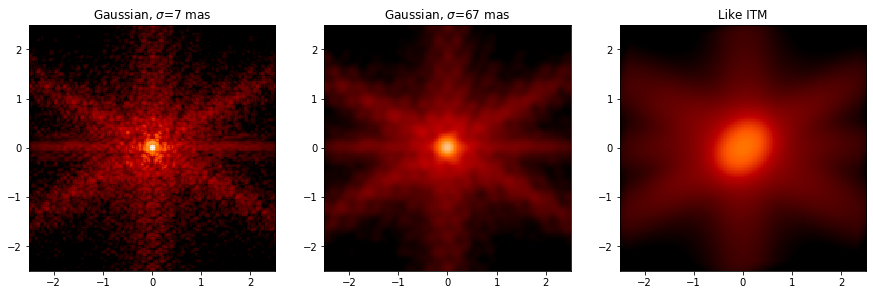

In [12]:
psf = nrc.calc_psf(nlambda=1, add_distortion=False)

nrc.options['jitter']='PCS=Coarse'
psf_coarse = nrc.calc_psf(nlambda=1, add_distortion=False)

nrc.options['jitter']='PCS=Coarse_Like_ITM'
psf_coarse_like_itm = nrc.calc_psf(nlambda=1, add_distortion=False)

fig, axes = plt.subplots(figsize=(15,5), ncols=3)

for ax, eachpsf, title in zip(axes, [psf, psf_coarse, psf_coarse_like_itm],
                             ['Gaussian, $\sigma$=7 mas', 'Gaussian, $\sigma$=67 mas', 'Like ITM']):

    webbpsf.display_psf(eachpsf, ext=1, ax=ax, colorbar=False, title=title)

In [20]:
nrc.detector = 'NRCB5'
nrc.filter = 'F480M'

nrc.options['jitter']='PCS=Coarse_Like_ITM'
grid = nrc.psf_grid(num_psfs=1, save=False, all_detectors=False,
                                   use_detsampled_psf=True, fov_pixels=1024,
                                   oversample=1, overwrite=False, add_distortion=False,
                                   nlambda=10)



Running instrument: NIRCam, filter: F480M
  Running detector: NRCB5
    Position 1/1: (1023, 1023) pixels


KernelSizeError: Kernel size must be odd in all axes.

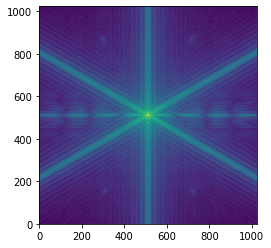

In [18]:
plt.imshow(np.log10(grid.data[0]))